Before the actuall usage you want to download the stopwords for nltk by running:

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

inside a python console.

To use AuDoLab in a project:

In [2]:
from AuDoLab import AuDoLab

Then you want to create an instance of the AuDoLab class

In [3]:
audo = AuDoLab.AuDoLab()

In this example we used publicly available data from the nltk package:

In [4]:
from nltk.corpus import reuters
import numpy as np
import pandas as pd

data = []

for fileid in reuters.fileids():
    tag, filename = fileid.split("/")
    data.append(
        (filename,
         ", ".join(
             reuters.categories(fileid)),
            reuters.raw(fileid)))

data = pd.DataFrame(data, columns=["filename", "categories", "text"])

Then you want to scrape abstracts, e.g. from IEEE with the abstract scraper (when using it the the IEEE scraper the first time, pypeteer will be downloaded automatically):

In [5]:
scraped_documents = audo.get_ieee(keywords=["cotton"], in_data="all_meta", pages=2)

The algorithm is iterating through 2 pages


  0%|                                                                                          | 0/203 [00:00<?, ?it/s]

Total number of abstracts that will be scraped: 203


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [03:15<00:00,  1.04it/s]


The same result could be achieved by directly specifying the querys url:

    #scraped_documents = audo.get_ieee("https://ieeexplore.ieee.org/search/searchresult.jsp?newsearch=true&queryText=cotton&highlight=true&returnFacets=ALL&returnType=SEARCH&matchPubs=true&rowsPerPage=100&pageNumber=1", pages=2)

#### The other two alternative scraping methods are arxiv.org and pubmed.com. They can be used using the following code:

    scraped_documents = audo.abstract_scraper(
        self, type="arxiv", url=url, pages=2, prepro=False, ngram_type=2
    )
    
When specifying the type to "pubmed" you can use url's from pubmed.
If prepro=True the scraped documents will be preprocessed directly after being scraped.

#### Take a look at the scraped documents

In [6]:
scraped_documents.head(3)

,abstract,title,citationCount,doi,totalDownloads,keywords,publicationYear,authors
0,Technologies currently used for cotton contami...,Recognition of cotton contaminants via X-ray m...,16,10.1109/TIA.2003.821647,251,"[Image recognition, Cotton, X-ray imaging, Ima...",2004,"[A. Pai, H. Sari-Sarraf, E.F. Hequet]"
3,This paper describes a method to assess the ri...,Assessing worker exposure and predicting the i...,None,10.1109/TPWRD.2004.834674,75,"[Arc discharges, Occupational health and safet...",2005,None
4,The optimal wavelength of near infrared (NIR) ...,Detection of foreign fibers in cotton using NI...,None,10.1109/ICIMW.2004.1422310,100,"[Cotton, Optical imaging, Light sources, Elect...",2004,"[Jia Dong Yao, Ding Tianhuai]"


#### The data as well as the scraped papers need to be preprocessed before use in the classifier:

    the function text_cleaning lets the user clean every (pandas) dataframe, one has only to specify the name of the column to be cleaned

In [7]:
preprocessed_target = audo.text_cleaning(data=data, column="text")

preprocessed_paper = audo.text_cleaning(
    data=scraped_documents, column="abstract")

target_tfidf, training_tfidf = audo.tf_idf(
    data=preprocessed_target,
    papers=preprocessed_paper,
    data_column="lemma",
    papers_column="lemma",
    features=100000,
)

start preprocessing the documents


100%|██████████████████████████████████████████████████████████████████████████| 10788/10788 [00:04<00:00, 2515.56it/s]


start preprocessing the documents


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 2717.28it/s]


#### Afterwards we can train and use the classifiers and choose the desired one:

In [8]:
o_svm_result = audo.one_class_svm(
    training=training_tfidf,
    predicting=target_tfidf,
    nus=np.round(np.arange(0.001, 0.5, 0.01), 7),
    quality_train=0.9,
    min_pred=0.001,
    max_pred=0.05,
)

result = audo.choose_classifier(preprocessed_target, o_svm_result, 0)

nu: 0.381 data predicted: 32 training_data predicted: 177


And finally you can estimate the topics of the data:

In [9]:
lda_model = audo.lda_modeling(data=result, num_topics=5)

audo.lda_visualize_topics(lda_model, type="pyldavis")

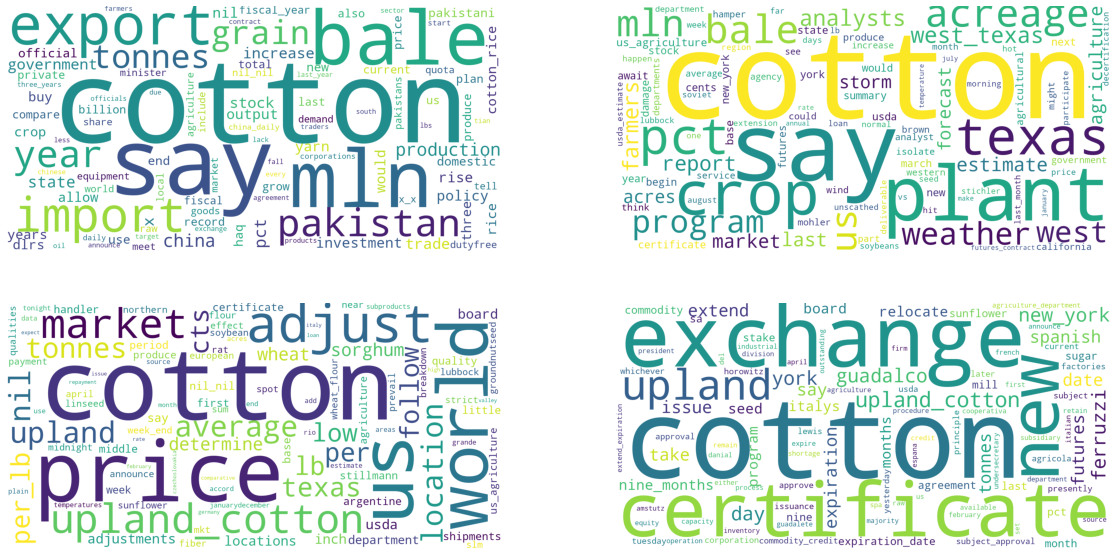

In [10]:
audo.lda_visualize_topics(lda_model, type="clouds", n_clouds=4)